In [ ]:
# import ds from kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [3]:
!kaggle competitions download -c titanic

  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 44.9MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.10MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 60.7MB/s]


In [ ]:
# import starter pack

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

df = pd.merge(train, test, how = 'outer')

In [ ]:
# find missing values

In [ ]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [ ]:
# Replace all missing values in the Age column with medians based on the person's gender

In [ ]:
df.groupby(['Pclass', 'Sex'])['Age'].median()

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64

In [ ]:
# let's fill values with age median and round off

In [ ]:
def set_null_age(cols):
    Age,Pclass,Sex = cols
    if pd.isnull(Age):
        if Pclass == 1: 
            if Sex == 'female':
                return 36
            else:
                return 42
        elif Pclass == 2: 
            if Sex == 'female':
                return 28
            else:
                return 29.5          
        elif Pclass == 3: 
            if Sex == 'female':
                return 22
            else:
                return 25  
    else:
        return Age

In [ ]:
df['Age']=df[['Age', 'Pclass', 'Sex']].apply(set_null_age, axis = 1)
df.Age = df.Age.apply('ceil').astype(int)

In [ ]:
# let's split Age using clusters

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering

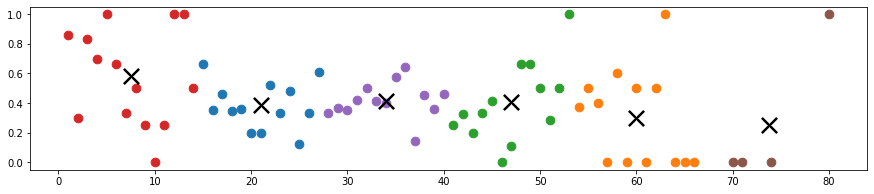

In [ ]:
N = 6
age = df.pivot_table(values = 'Survived', index = 'Age').sort_values('Age').reset_index()
X = age[['Age', 'Survived']]

clust = KMeans(n_clusters=N).fit(X)
c = clust.cluster_centers_

# we can take colors fro mathplotlib (10 colors - max 10 clusters)
clrs = list(colors.TABLEAU_COLORS.keys())

fig = plt.figure(figsize=(15, 3))
for x, y in zip(age.Age, age.Survived):
    cl = clust.predict(np.array([x,y]).reshape(1, -1))
    plt.scatter(x, y, s=75, c = clrs[cl[0]])
    for i in range(len(c)):
        plt.scatter(c[i][0], c[i][1], s=200, marker="x", c="black")
plt.show()

In [ ]:
# find dropped age

In [ ]:
age['age_grouped'] = clust.labels_
age = age.drop('Survived', axis = 1)

In [ ]:
df = pd.merge(df, age, on = 'Age', how = 'left')
df[pd.isnull(df['age_grouped'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_grouped
972,973,NaN,1,"Straus, Mr. Isidor",male,67,1,0,PC 17483,221.7792,C55 C57,S,NaN
987,988,NaN,1,"Cavendish, Mrs. Tyrell William (Julia Florence...",female,76,1,0,19877,78.8500,C46,S,NaN


In [ ]:
# we fill set nearest clusters numbers for those rows
df.loc[972, 'age_grouped'] = df['age_grouped'][df.Age == 66].min()
df.loc[987, 'age_grouped'] = df['age_grouped'][df.Age == 74].min()

In [ ]:
#find age dependence on surviving

             Survived
age_grouped          
5.0          0.142857
0.0          0.328283
1.0          0.348837
2.0          0.363636
4.0          0.433198
3.0          0.584416


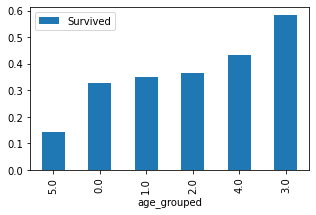

In [ ]:
col = 'age_grouped'
target = 'Survived'
sort = target
print(df[:891].pivot_table(values = target, index = col).sort_values(sort))
df[:891].pivot_table(values = target, index = col).sort_values(sort).plot(kind = 'bar', figsize=(5,3))

In [ ]:
# 5 and 2 groups are more lucky to survive

In [ ]:
# find duplicates in Name
df.Name.nunique()

1307

In [ ]:
df[df.duplicated('Name')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_grouped
891,892,NaN,3,"Kelly, Mr. James",male,35,0,0,330911,7.8292,NaN,Q,4.0
897,898,NaN,3,"Connolly, Miss. Kate",female,30,0,0,330972,7.6292,NaN,Q,4.0


In [ ]:
df[(df.Name == 'Kelly, Mr. James') | (df.Name == 'Connolly, Miss. Kate')].sort_values('Name')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_grouped
289,290,1.0,3,"Connolly, Miss. Kate",female,22,0,0,370373,7.7500,NaN,Q,0.0
897,898,NaN,3,"Connolly, Miss. Kate",female,30,0,0,330972,7.6292,NaN,Q,4.0
696,697,0.0,3,"Kelly, Mr. James",male,44,0,0,363592,8.0500,NaN,S,2.0
891,892,NaN,3,"Kelly, Mr. James",male,35,0,0,330911,7.8292,NaN,Q,4.0


In [ ]:
# let's work with Titles, replace them 

In [ ]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [ ]:
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'other')

df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [ ]:
#find title dependence on surviving

        Survived
Title           
Mr      0.156673
other   0.347826
Master  0.575000
Miss    0.702703
Mrs     0.793651


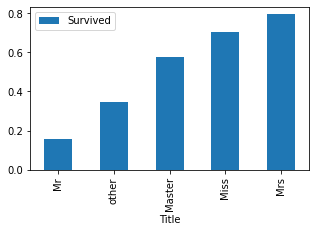

In [ ]:
col = 'Title'
target = 'Survived'
sort = target
print(df[:891].pivot_table(values = target, index = col).sort_values(sort))
df[:891].pivot_table(values = target, index = col).sort_values(sort).plot(kind = 'bar', figsize=(5,3))

In [ ]:
# Mrs and Miss are more lucky to survive

In [ ]:
for i in ['Title']:
    
    a = 0 #this is the digit we gonna use to replace the values in the two column
    print(i)   # print the column (just to keep tack of the process)
    for valu in df[i].sort_values().unique():   # now we get the unique values in the the selected column sort the  value 
                                                    #cause we don't want the values to be raplace randomly
            
            
        df.loc[df[i] == valu, i ] = a       # loc the rows tha have the selected value, then replace all those values by a variable
            
        print(valu,' = ',a)   #we display the results
        a +=1  # then we update the  variable a

Title
Master  =  0
Miss  =  1
Mr  =  2
Mrs  =  3
other  =  4


In [ ]:
# let's find dependence between duplicated tickets and surviving

In [ ]:
df['ticket_double'] = 0

In [ ]:
df['ticket_double'][df.duplicated('Ticket')] = 1

               Survived
ticket_double          
0              0.350954
1              0.490476


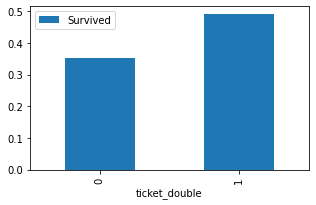

In [ ]:
col = 'ticket_double'
target = 'Survived'
sort = col
print(df[:891].pivot_table(values = target, index = col).sort_values(sort))
df[:891].pivot_table(values = target, index = col).sort_values(sort).plot(kind = 'bar', figsize=(5,3))

In [ ]:
# people with duplicated tickets, almost 50% are more lucky to survive

In [ ]:
# let's fill fare values with fare median and round off

In [ ]:
df[pd.isnull(df.Fare) | (df.Fare == 0)].Fare.count()

17

In [ ]:
df.groupby(['Pclass'])['Fare'].median().round(2)

Pclass
1    60.00
2    15.05
3     8.05
Name: Fare, dtype: float64

In [ ]:
def set_null_fare(cols):
    Fare, Pclass = cols
    if Fare == 0 or pd.isnull(Fare):
        if Pclass == 1:
            return 63.36
        elif Pclass == 2:
            return 15.75
        elif Pclass == 3:
            return 8.05
    else:
        return Fare

df['Fare']=df[['Fare', 'Pclass']].apply(set_null_fare, axis = 1).round(2)

In [ ]:
# group Fare by median score

def set_gr_fare(col):
    Fare = col
    if Fare < 8.05:
        return 1
    elif Fare < 15.05:
        return 2
    elif Fare < 30:
        return 3
    else:
        return 4

In [ ]:
df['fare_grouped']=df['Fare'].apply(set_gr_fare)

In [ ]:
# fare and surviving dependence

              Survived
fare_grouped          
1             0.219008
2             0.281106
3             0.453125
4             0.587500


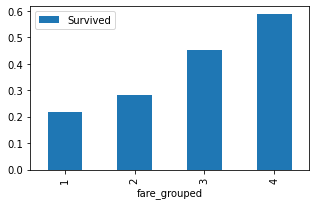

In [ ]:
col = 'fare_grouped'
target = 'Survived'
sort = col
print(df[:891].pivot_table(values = target, index = col).sort_values(sort))
df[:891].pivot_table(values = target, index = col).sort_values(sort).plot(kind = 'bar', figsize=(5,3))

In [ ]:
# People who paid more than 30 are closer to survive

In [ ]:
# sex and survivng dependence

        Survived
Sex             
male    0.188908
female  0.742038


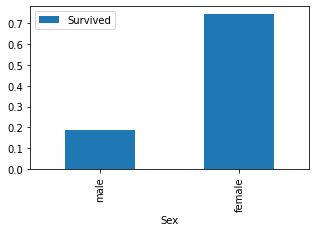

In [ ]:
col = 'Sex'
target = 'Survived'
sort = target
print(df[:891].pivot_table(values = target, index = col).sort_values(sort))
df[:891].pivot_table(values = target, index = col).sort_values(sort).plot(kind = 'bar', figsize=(5,3))

In [ ]:
# wow! 74 % vs 19%

In [ ]:
df['Sex'] = df['Sex'].map({'male':1, 'female':2})

In [ ]:
# embarked and survivng dependence

          Survived
Embarked          
S         0.336957
Q         0.389610
C         0.553571


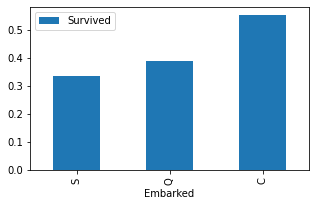

In [ ]:
col = 'Embarked'
target = 'Survived'
sort = target
print(df[:891].pivot_table(values = target, index = col).sort_values(sort))
df[:891].pivot_table(values = target, index = col).sort_values(sort).plot(kind = 'bar', figsize=(5,3))

In [ ]:
df[pd.isnull(df.Embarked)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_grouped,Title,ticket_double,fare_grouped
61,62,1.0,1,"Icard, Miss. Amelie",2,38,0,0,113572,80.0,B28,NaN,4.0,1,0,4
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",2,62,0,0,113572,80.0,B28,NaN,1.0,3,1,4


In [ ]:
df.loc[(61,829), 'Embarked'] = 'S'

In [ ]:
df['Embarked'] = df['Embarked'].map({"S": 1, "Q": 2, "C": 3})

In [ ]:
df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [ ]:
df['Cabin'] = df['Cabin'].str.extract('([A-Za-z]+)', expand = False)

In [ ]:
df['Cabin'] = df['Cabin'].map({'A':1, 'G':2, 'C':3, 'F':4, 'B':5, 'E':6, 'D':7, 'T':0})

In [ ]:
df['Cabin'] = df['Cabin'].fillna(0)

       Survived
Cabin          
0.0    0.299419
1.0    0.466667
2.0    0.500000
3.0    0.593220
4.0    0.615385
5.0    0.744681
6.0    0.750000
7.0    0.757576


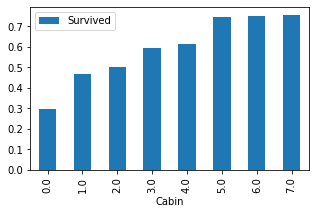

In [ ]:
col = 'Cabin'
target = 'Survived'
sort = col
print(df[:891].pivot_table(values = target, index = col).sort_values(sort))
df[:891].pivot_table(values = target, index = col).sort_values(sort).plot(kind = 'bar', figsize=(5,3))

In [ ]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'age_grouped', 'Title',
       'ticket_double', 'fare_grouped'],
      dtype='object')

In [6]:
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)

In [ ]:
df.isnull().sum()

Survived         418
Pclass             0
Sex                0
Age                0
SibSp              0
Parch              0
Fare               1
Cabin              0
Embarked           0
age_grouped        0
Title              0
ticket_double      0
fare_grouped       0
dtype: int64

In [ ]:
df.dtypes

Survived         float64
Pclass             int64
Sex                int64
Age                int64
SibSp              int64
Parch              int64
Fare             float64
Cabin            float64
Embarked           int64
age_grouped      float64
Title             object
ticket_double      int64
fare_grouped       int64
dtype: object

In [ ]:
np.asarray(df)


array([[0.0, 3, 1, ..., 2, 0, 1],
       [1.0, 1, 2, ..., 3, 0, 4],
       [1.0, 3, 2, ..., 1, 0, 1],
       ...,
       [nan, 3, 1, ..., 2, 0, 1],
       [nan, 3, 1, ..., 2, 0, 2],
       [nan, 3, 1, ..., 0, 1, 3]], dtype=object)

In [ ]:
bfull = df.drop(['Age', 'Fare'], axis = 1)
bfull = bfull.fillna(0).astype(int)

dummy_col=[ 'Pclass',
            'Sex',
            'Cabin',
            'Embarked',
            'age_grouped',
            'Title',
            'ticket_double',
            'fare_grouped']
dummy = pd.get_dummies(bfull[dummy_col], columns=dummy_col)
bfull = pd.concat([dummy, bfull], axis = 1)
bfull.drop([
            'Pclass',
            'Sex',
            'SibSp',
            'Parch',
            'Cabin',
            'Embarked',
            'age_grouped',
            'Title',
            'ticket_double',
            'fare_grouped'], inplace = True, axis = 1)

In [ ]:
# list of all features 
list(bfull.columns)

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_1',
 'Sex_2',
 'Cabin_0',
 'Cabin_1',
 'Cabin_2',
 'Cabin_3',
 'Cabin_4',
 'Cabin_5',
 'Cabin_6',
 'Cabin_7',
 'Embarked_1',
 'Embarked_2',
 'Embarked_3',
 'age_grouped_0',
 'age_grouped_1',
 'age_grouped_2',
 'age_grouped_3',
 'age_grouped_4',
 'age_grouped_5',
 'Title_0',
 'Title_1',
 'Title_2',
 'Title_3',
 'Title_4',
 'ticket_double_0',
 'ticket_double_1',
 'fare_grouped_1',
 'fare_grouped_2',
 'fare_grouped_3',
 'fare_grouped_4',
 'Survived']

In [ ]:
#correlation matrix

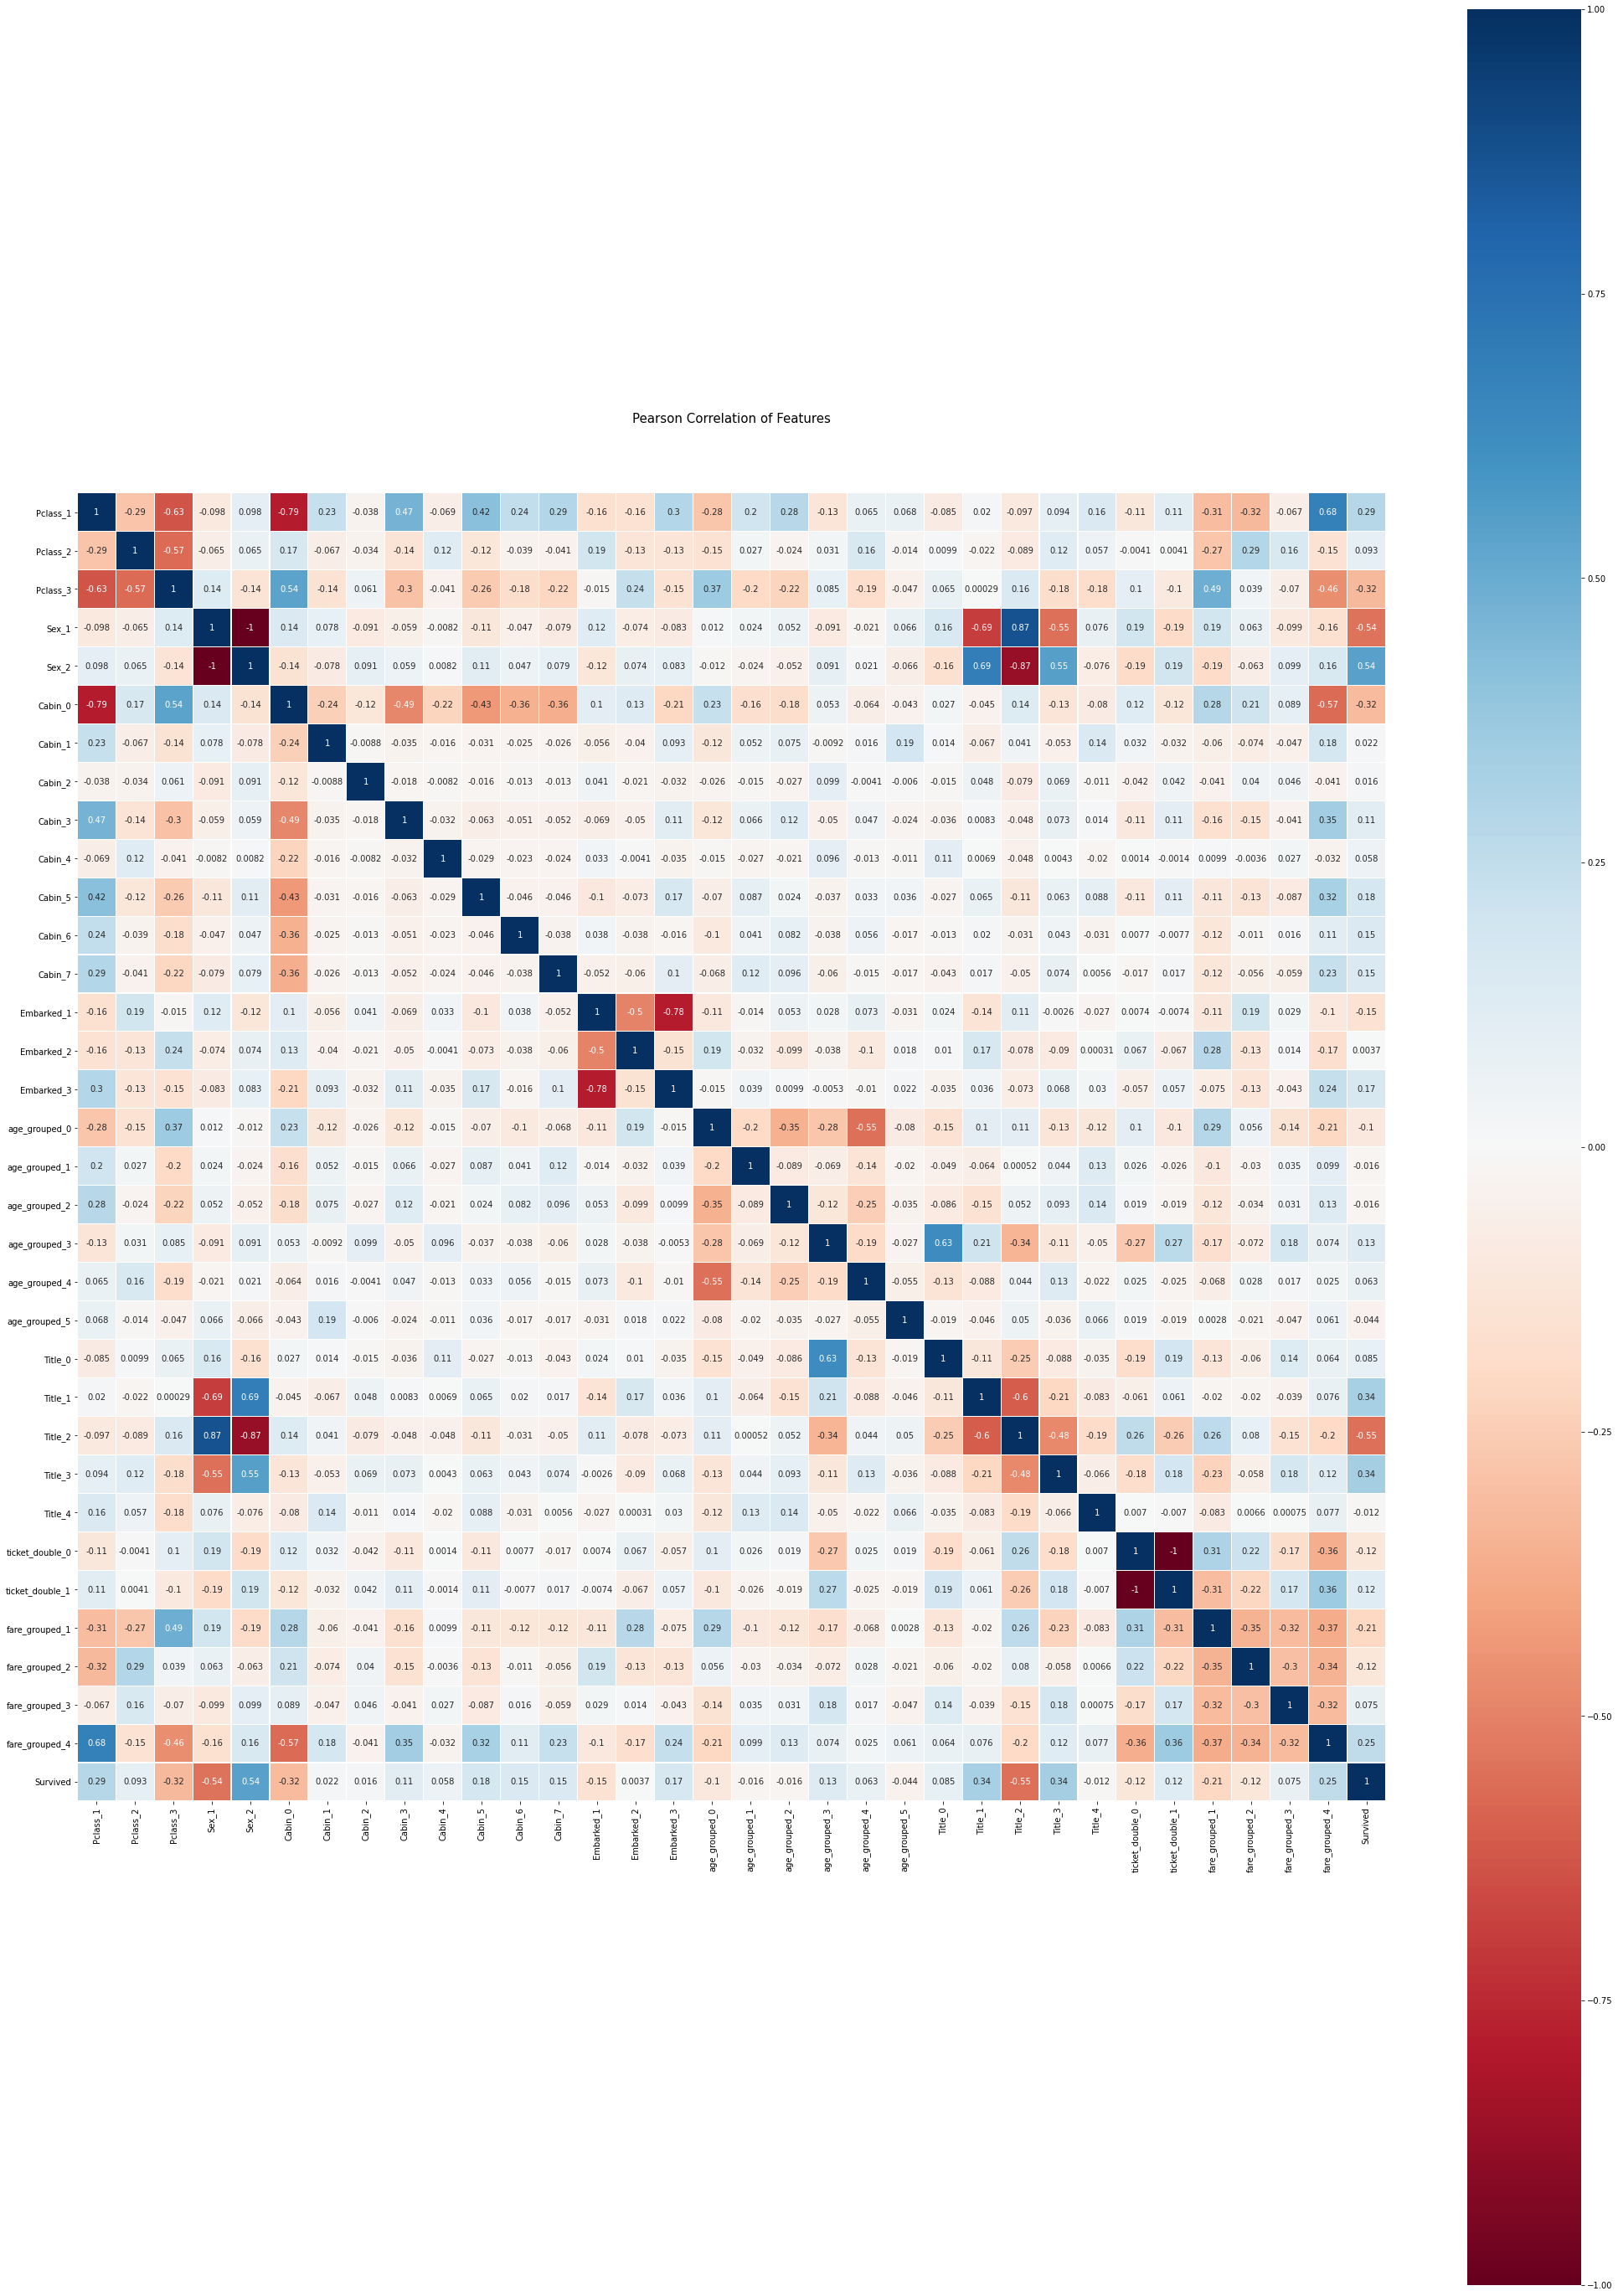

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(35,50))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(bfull[:891].astype(int).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix

In [ ]:
df.shape

(891, 34)

In [ ]:
X = df[:473].drop(['Survived'], axis = 1)
y = df[:473].Survived

In [ ]:
X.shape

(473, 33)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
X_train.describe()

,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Cabin_0,Cabin_1,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6,Cabin_7,Embarked_1,Embarked_2,Embarked_3,age_grouped_0,age_grouped_1,age_grouped_2,age_grouped_3,age_grouped_4,age_grouped_5,Title_0,Title_1,Title_2,Title_3,Title_4,ticket_double_0,ticket_double_1,fare_grouped_1,fare_grouped_2,fare_grouped_3,fare_grouped_4
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,0.244012,0.206587,0.549401,0.654192,0.345808,0.766467,0.020958,0.002994,0.064371,0.013473,0.049401,0.043413,0.038922,0.736527,0.089820,0.173653,0.441617,0.044910,0.136228,0.082335,0.285928,0.008982,0.049401,0.202096,0.589820,0.140719,0.017964,0.760479,0.239521,0.275449,0.230539,0.220060,0.273952
std,0.429822,0.405160,0.497926,0.475988,0.475988,0.423395,0.143351,0.054677,0.245597,0.115375,0.216867,0.203938,0.193554,0.440847,0.286138,0.379094,0.496952,0.207262,0.343287,0.275081,0.452194,0.094418,0.216867,0.401864,0.492235,0.347992,0.132920,0.427111,0.427111,0.447075,0.421493,0.414597,0.446319
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# fit model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 800, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 3, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 15)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 15)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 200, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rfc_2 = RandomForestClassifier()
n_estimators = [722]
max_features = ['log2']
max_depth = [6, 7, 12, 15]
min_samples_split = [8, 32]
min_samples_leaf = [2,3,4,5,6,7,8]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc_2, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_3 = gs.best_estimator_
best_params = gs.best_params_
best_params

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:  2.0min finished


{'bootstrap': False,
 'max_depth': 6,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 32,
 'n_estimators': 722}

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
model_rfc = RandomForestClassifier(**(best_params)).fit(X_train, y_train)
Y_pred_RF = model_rfc.predict(X_test)
RF = round(metrics.accuracy_score(y_test, Y_pred_RF), 5)
print(RF)

0.81614


In [ ]:
model_lr = LogisticRegression(random_state=1, solver='liblinear', penalty = 'l1').fit(X_train, y_train)
Y_pred_LR = model_lr.predict(X_test).round()
LR = round(metrics.accuracy_score(y_test, Y_pred_LR), 5)
print(LR)

0.82063


In [ ]:
model_rc = RidgeClassifier(random_state=0).fit(X_train, y_train)
Y_pred_RC = model_rc.predict(X_test)
RC = round(metrics.accuracy_score(y_test, Y_pred_RC), 5)
print(RC)

0.79372


In [ ]:
model_knn = KNeighborsClassifier(n_neighbors = 4, weights = 'uniform', algorithm = 'brute').fit(X_train, y_train)
Y_pred_KNN = model_knn.predict(X_test)
KNN = round(metrics.accuracy_score(y_test, Y_pred_KNN), 5)
print(KNN)

0.78027


In [ ]:
model_gnb = GaussianNB().fit(X_train, y_train)
Y_pred_GNB = model_gnb.predict(X_test)
GNB = round(metrics.accuracy_score(y_test, Y_pred_GNB), 5)
print(GNB)

0.78027


In [ ]:
model_dtc = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 1, min_samples_split = 2).fit(X_train, y_train)
Y_pred_DTC = model_dtc.predict(X_test)
DTC = round(metrics.accuracy_score(y_test, Y_pred_DTC), 5)
print(DTC)

0.79372


In [ ]:
model_xgbc = XGBClassifier(random_state=0, learning_rate = 0.01, 
                              max_depth = 2, n_estimators = 20, n_jobs=-1).fit(X_train, y_train)
Y_pred_XGBC = model_xgbc.predict(X_test)
XGBC = round(metrics.accuracy_score(y_test, Y_pred_XGBC), 5)
print(XGBC)

0.7713


In [ ]:
model_lrcv = LogisticRegressionCV().fit(X_train, y_train)
Y_pred_LRCV = model_lrcv.predict(X_test)
LRCV = round(metrics.accuracy_score(y_test, Y_pred_LRCV), 5)
print(LRCV)

0.81166


In [ ]:
model_gbc = GradientBoostingClassifier().fit(X_train, y_train)
Y_pred_GBC = model_gbc.predict(X_test)
GBC = round(metrics.accuracy_score(y_test, Y_pred_GBC), 5)
print(GBC)

0.83408


In [ ]:
test_X = df[473:].drop(['Survived'], axis=1)
test_y = df[473:].Survived

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(test_X, test_y, test_size=0.25, random_state=0)

In [ ]:
test_gbc = GradientBoostingClassifier().fit(X_train, y_train)
Y_pred_GBC = test_gbc.predict(test_X)

In [ ]:
test_X.shape

(418, 33)

In [ ]:
predictions = model_gbc.predict(test_X)
ID = test.PassengerId

In [ ]:
predictions.shape

(418,)

In [ ]:
output = pd.DataFrame({'PassengerId': ID, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")


Your submission was successfully saved!


In [ ]:
files.download('my_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>